<a href="https://colab.research.google.com/github/dean-sh/Movie-Ratings-with-SVD/blob/master/Collaborating%20Filltering%20%2C%20Matrix%20Factorization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

MovieLens Recommendations - Collaborating Filltering, Matrix Factorization
=============================================
## Dean Shabi, Dedi Kovatch, July 2019
## Final Project for TCDS - Technion Data Science Specialization

MovieLens data sets were collected by the GroupLens Research Project
at the University of Minnesota.
 
This data set consists of:
	* 100,000 ratings (1-5) from 943 users on 1682 movies. 
	* Each user has rated at least 20 movies. 
        * Simple demographic info for the users (age, gender, occupation, zip)

The data was collected through the MovieLens web site
(movielens.umn.edu) during the seven-month period from September 19th, 
1997 through April 22nd, 1998. This data has been cleaned up - users
who had less than 20 ratings or did not have complete demographic
information were removed from this data set. Detailed descriptions of
the data file can be found at the end of this file.


## Data Description




Here are brief descriptions of the data.

ml-data.tar.gz   -- Compressed tar file.  To rebuild the u data files do this:
                gunzip ml-data.tar.gz
                tar xvf ml-data.tar
                mku.sh

u.data     -- The full u data set, 100000 ratings by 943 users on 1682 items.
              Each user has rated at least 20 movies.  Users and items are
              numbered consecutively from 1.  The data is randomly
              ordered. This is a tab separated list of 
	         user id | item id | rating | timestamp. 
              The time stamps are unix seconds since 1/1/1970 UTC   

u.info     -- The number of users, items, and ratings in the u data set.

u.item     -- Information about the items (movies); this is a tab separated
              list of
              movie id | movie title | release date | video release date |
              IMDb URL | unknown | Action | Adventure | Animation |
              Children's | Comedy | Crime | Documentary | Drama | Fantasy |
              Film-Noir | Horror | Musical | Mystery | Romance | Sci-Fi |
              Thriller | War | Western |
              The last 19 fields are the genres, a 1 indicates the movie
              is of that genre, a 0 indicates it is not; movies can be in
              several genres at once.
              The movie ids are the ones used in the u.data data set.

u.genre    -- A list of the genres.

u.user     -- Demographic information about the users; this is a tab
              separated list of
              user id | age | gender | occupation | zip code
              The user ids are the ones used in the u.data data set.

u.occupation -- A list of the occupations.

u1.base    -- The data sets u1.base and u1.test through u5.base and u5.test
u1.test       are 80%/20% splits of the u data into training and test data.
u2.base       Each of u1, ..., u5 have disjoint test sets; this if for
u2.test       5 fold cross validation (where you repeat your experiment
u3.base       with each training and test set and average the results).
u3.test       These data sets can be generated from u.data by mku.sh.
u4.base
u4.test
u5.base
u5.test

ua.base    -- The data sets ua.base, ua.test, ub.base, and ub.test
ua.test       split the u data into a training set and a test set with
ub.base       exactly 10 ratings per user in the test set.  The sets
ub.test       ua.test and ub.test are disjoint.  These data sets can
              be generated from u.data by mku.sh.

allbut.pl  -- The script that generates training and test sets where
              all but n of a users ratings are in the training data.

mku.sh     -- A shell script to generate all the u data sets from u.data.

## Imports




In [0]:
import numpy as np
import pandas as pd
import collections
import seaborn as sns
%matplotlib inline
# from mpl_toolkits.mplot3d import Axes3D
from IPython import display
from matplotlib import pyplot as plt
import sklearn
import sklearn.manifold
# import tensorflow as tf
# tf.logging.set_verbosity(tf.logging.ERROR)

# # Add some convenience functions to Pandas DataFrame.
# pd.options.display.max_rows = 10
# pd.options.display.float_format = '{:.3f}'.format



# # Install Altair and activate its colab renderer.
# print("Installing Altair...")
# !pip install git+git://github.com/altair-viz/altair.git
# import altair as alt
# alt.data_transformers.enable('default', max_rows=None)
# alt.renderers.enable('colab')
# print("Done installing Altair.")

# # Install spreadsheets and import authentication module.
# USER_RATINGS = False
# !pip install --upgrade -q gspread
# from google.colab import auth
# import gspread
# from oauth2client.client import GoogleCredentials

## **Importing dataset, preprocessing**




In [0]:
# download the MovieLens Data, and create DataFrames containing movies, users, and ratings.

print("Downloading movielens data...")
import zipfile
import urllib.request

urllib.request.urlretrieve("http://files.grouplens.org/datasets/movielens/ml-100k.zip", "movielens.zip")
zip_ref = zipfile.ZipFile('movielens.zip', "r")
zip_ref.extractall()
print("Done. Dataset contains:")
print(zip_ref.read('ml-100k/u.info'))

In [0]:
# Load each data set (users, movies, and ratings).
users_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv(
    'ml-100k/u.user', sep='|', names=users_cols, encoding='latin-1')

ratings_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings = pd.read_csv(
    'ml-100k/u.data', sep='\t', names=ratings_cols, encoding='latin-1')

# The movies file contains a binary feature for each genre.
genre_cols = [
    "genre_unknown", "Action", "Adventure", "Animation", "Children", "Comedy",
    "Crime", "Documentary", "Drama", "Fantasy", "Film-Noir", "Horror",
    "Musical", "Mystery", "Romance", "Sci-Fi", "Thriller", "War", "Western"
]
movies_cols = [
    'movie_id', 'title', 'release_date', "video_release_date", "imdb_url"] + genre_cols

movies = pd.read_csv(
    'ml-100k/u.item', sep='|', names=movies_cols, encoding='latin-1')


Some Preproccessing

In [0]:
# Since the ids start at 1, we shift them to start at 0.
users["user_id"] = users["user_id"].apply(lambda x: str(x-1))
movies["movie_id"] = movies["movie_id"].apply(lambda x: str(x-1))
movies["year"] = movies['release_date'].apply(lambda x: str(x).split('-')[-1])
ratings["movie_id"] = ratings["movie_id"].apply(lambda x: str(x-1))
ratings["user_id"] = ratings["user_id"].apply(lambda x: str(x-1))
ratings["rating"] = ratings["rating"].apply(lambda x: float(x))

# Compute the number of movies to which a genre is assigned.
genre_occurences = movies[genre_cols].sum().to_dict()

# Since some movies can belong to more than one genre, we create different
# 'genre' columns as follows:
# - all_genres: all the active genres of the movie.
# - genre: randomly sampled from the active genres.
def mark_genres(movies, genres):
    def get_random_genre(gs):
        active = [genre for genre, g in zip(genres, gs) if g==1]
        if len(active) == 0:
            return 'Other'
        return np.random.choice(active)
    def get_all_genres(gs):
        active = [genre for genre, g in zip(genres, gs) if g==1]
        if len(active) == 0:
            return 'Other'
        return '-'.join(active)
    movies['genre'] = [
        get_random_genre(gs) for gs in zip(*[movies[genre] for genre in genres])]
    movies['all_genres'] = [
        get_all_genres(gs) for gs in zip(*[movies[genre] for genre in genres])]

mark_genres(movies, genre_cols)

In [0]:
# Create one merged DataFrame containing all the movielens data.
movielens = ratings.merge(movies, on='movie_id').merge(users, on='user_id')

# Utility to split the data into training and test sets.
def split_dataframe(df, holdout_fraction=0.1):
    """Splits a DataFrame into training and test sets.
    Args:
    df: a dataframe.
    holdout_fraction: fraction of dataframe rows to use in the test set.
    Returns:
    train: dataframe for training
    test: dataframe for testing
    """
    test = df.sample(frac=holdout_fraction, replace=False)
    train = df[~df.index.isin(test.index)]
    return train, test

In [0]:
movies.head()

,movie_id,title,release_date,video_release_date,imdb_url,genre_unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,year,genre,all_genres
0,0,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1995,Comedy,Animation-Children-Comedy
1,1,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1995,Adventure,Action-Adventure-Thriller
2,2,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1995,Thriller,Thriller
3,3,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1995,Comedy,Action-Comedy-Drama
4,4,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1995,Crime,Crime-Drama-Thriller


In [0]:
users.head()

,user_id,age,sex,occupation,zip_code
0,0,24,M,technician,85711
1,1,53,F,other,94043
2,2,23,M,writer,32067
3,3,24,M,technician,43537
4,4,33,F,other,15213


In [0]:
ratings.head()

,user_id,movie_id,rating,unix_timestamp
0,195,241,3.0,881250949
1,185,301,3.0,891717742
2,21,376,1.0,878887116
3,243,50,2.0,880606923
4,165,345,1.0,886397596


In [0]:
movielens.head()

,user_id,movie_id,rating,unix_timestamp,title,release_date,video_release_date,imdb_url,genre_unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,year,genre,all_genres,age,sex,occupation,zip_code
0,195,241,3.0,881250949,Kolya (1996),24-Jan-1997,NaN,http://us.imdb.com/M/title-exact?Kolya%20(1996),0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1997,Comedy,Comedy,49,M,writer,55105
1,195,256,2.0,881251577,Men in Black (1997),04-Jul-1997,NaN,http://us.imdb.com/M/title-exact?Men+in+Black+...,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1997,Sci-Fi,Action-Adventure-Comedy-Sci-Fi,49,M,writer,55105
2,195,110,4.0,881251793,"Truth About Cats & Dogs, The (1996)",26-Apr-1996,NaN,http://us.imdb.com/M/title-exact?Truth%20About...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1996,Comedy,Comedy-Romance,49,M,writer,55105
3,195,24,4.0,881251955,"Birdcage, The (1996)",08-Mar-1996,NaN,"http://us.imdb.com/M/title-exact?Birdcage,%20T...",0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1996,Comedy,Comedy,49,M,writer,55105
4,195,381,4.0,881251843,"Adventures of Priscilla, Queen of the Desert, ...",01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?Adventures%20...,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1994,Comedy,Comedy-Drama,49,M,writer,55105


# Collaborating Filltering with Surprise library

In [0]:
!pip install scikit-surprise

from surprise import Reader
from surprise import Dataset
from surprise.model_selection import cross_validate
from surprise import NormalPredictor
from surprise import KNNBasic
from surprise import KNNWithMeans
from surprise import KNNWithZScore
from surprise import KNNBaseline
from surprise import SVD
from surprise import BaselineOnly
from surprise import SVDpp
from surprise import NMF
from surprise import SlopeOne
from surprise import CoClustering
from surprise.accuracy import rmse
from surprise import accuracy
from surprise.model_selection import train_test_split

     |████████████████████████████████| 3.3MB 2.9MB/s 
  Stored in directory: /root/.cache/pip/wheels/ec/c0/55/3a28eab06b53c220015063ebbdb81213cd3dcbb72c088251ec
Successfully built scikit-surprise


In [0]:
min_item_clicks = 50
filter_items = movielens['movie_id'].value_counts() > min_item_clicks
filter_items = filter_items[filter_items].index.tolist()

min_user_clicks = 50
filter_users = movielens['user_id'].value_counts() > min_user_clicks
filter_users = filter_users[filter_users].index.tolist()

df_filtered = movielens[(movielens['movie_id'].isin(filter_items)) & (movielens['user_id'].isin(filter_users))]
print('The original data frame shape:\t{}'.format(movielens.shape))
print('The new data frame shape:\t{}'.format(df_filtered.shape))

The original data frame shape:	(100000, 34)
The new data frame shape:	(72829, 34)


In [0]:
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df_filtered[['user_id', 'movie_id', 'rating']], reader)

In [0]:
benchmark = []

# Iterate over all algorithms
for algo in [SVD(), SVDpp(),SlopeOne(), NMF(), NormalPredictor(), KNNBaseline(), KNNBasic(), KNNWithMeans(), KNNWithZScore(), BaselineOnly(), CoClustering()]:

    # Perform cross validation
    print('statring cv for {}'.format(algo))
    results = cross_validate(algo, data, measures=['RMSE'], cv=5, verbose=False)
    
    # Get results & appensurprise_results = pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')d algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algo).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)
    
    

In [0]:
surprise_results = pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')
surprise_results

,test_rmse,fit_time,test_time
Algorithm,,,
SVDpp,0.911311,161.063439,2.572903
KNNBaseline,0.920567,0.449645,3.724718
SVD,0.926022,4.540039,0.141301
SlopeOne,0.934167,0.501804,2.111923
BaselineOnly,0.935144,0.117489,0.133268
KNNWithMeans,0.937647,0.363125,3.235781
KNNWithZScore,0.938816,0.412725,3.479334
CoClustering,0.945486,1.077938,0.169708
NMF,0.951034,4.721857,0.149676


In [0]:
#HyperParameterTunning for BaseLineOnly

benchmark = []

methods = 'als'
n_epochs = [10,15,20,40]
reg_us = [2, 5 ,10]
reg_is = [2, 5, 10]

for n_epoch in n_epochs:
  for reg_u in reg_us:
    for reg_i in reg_is:
      bsl_options = {'method': 'als',
                     'n_epochs': n_epoch,
                     'reg_u': reg_u,
                     'reg_i': reg_i}

      algo = BaselineOnly(bsl_options=bsl_options)
      results = cross_validate(algo, data, measures=['RMSE'], cv=5, verbose=False)

      tmp = pd.DataFrame.from_dict(results).mean(axis=0)
      tmp = tmp.append(pd.Series([str(algo).split(' ')[0].split('.')[-1]], index=['Algorithm']))
      tmp['n_epochs'] = n_epoch
      tmp['reg_u'] = reg_u
      tmp['reg_i'] = reg_i
      benchmark.append(tmp)


In [0]:
surprise_results = pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')
surprise_results

,test_rmse,fit_time,test_time,n_epochs,reg_u,reg_i
Algorithm,,,,,,
BaselineOnly,0.918615,0.265777,0.110717,40,2,2
BaselineOnly,0.918651,0.091991,0.126337,10,10,2
BaselineOnly,0.918732,0.264995,0.131282,40,2,5
BaselineOnly,0.918965,0.145354,0.127485,20,10,2
BaselineOnly,0.919010,0.146003,0.110739,20,10,5
BaselineOnly,0.919020,0.272649,0.113949,40,2,10
BaselineOnly,0.919061,0.086128,0.119886,10,2,5
BaselineOnly,0.919105,0.088744,0.133683,10,5,2
BaselineOnly,0.919206,0.090425,0.129215,10,5,5


In [0]:
trainset, testset = train_test_split(data, test_size=0.25)
bsl_options = {'method': 'als',
               'n_epochs': 40,
               'reg_u': 2,
               'reg_i': 2}

algo = BaselineOnly(bsl_options=bsl_options)
predictions = algo.fit(trainset).test(testset)
accuracy.rmse(predictions)

Estimating biases using als...
RMSE: 0.9256


0.9255923566007465

In [0]:
def get_Iu(uid):
    """ return the number of items rated by given user
    args: 
      uid: the id of the user
    returns: 
      the number of items rated by the user
    """
    try:
        return len(trainset.ur[trainset.to_inner_uid(uid)])
    except ValueError: # user was not part of the trainset
        return 0
    
def get_Ui(iid):
    """ return number of users that have rated given item
    args:
      iid: the raw id of the item
    returns:
      the number of users that have rated the item.
    """
    try: 
        return len(trainset.ir[trainset.to_inner_iid(iid)])
    except ValueError:
        return 0
    
df = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])
df['Iu'] = df.uid.apply(get_Iu)
df['Ui'] = df.iid.apply(get_Ui)
df['err'] = abs(df.est - df.rui)


In [0]:
df_ToMerge =  movies


df_ToMerge =  movielens[['user_id', 'movie_id', 'rating', 'title',
       'genre_unknown','Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime',
       'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical',
       'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western', 'year',
       'genre', 'all_genres', 'age', 'sex', 'occupation']]

df_ToMerge.rename(columns={'movie_id': 'iid'}, inplace=True)
df = df.merge(df_ToMerge, on='iid', how='left' )

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


In [0]:
df.head(2)

,uid,iid,rui,est,details,Iu,Ui,err,user_id,rating,title,genre_unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,year,genre,all_genres,age,sex,occupation
0,718,356,4.0,3.818739,{'was_impossible': False},47,172,0.181261,153,4.0,One Flew Over the Cuckoo's Nest (1975),0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1975,Drama,Drama,25,M,student
1,718,356,4.0,3.818739,{'was_impossible': False},47,172,0.181261,295,5.0,One Flew Over the Cuckoo's Nest (1975),0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1975,Drama,Drama,43,F,administrator


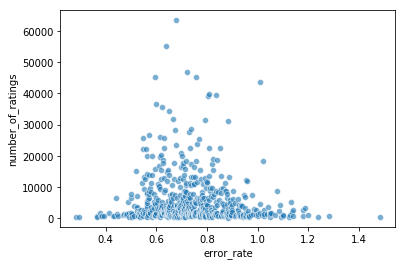

In [0]:
temp1 = df.loc[:,('title', 'err')].groupby('title').mean().sort_values(by = 'err')
temp2 = df['title'].value_counts()
temp3 = temp1.join(temp2, on = 'title',  how='left', lsuffix='_caller')
temp3.rename(columns={'err': 'error_rate', 'title': 'number_of_ratings'}, inplace=True)

sns.scatterplot(data = temp3, x ='error_rate' , y = 'number_of_ratings', alpha= 0.6)

In [0]:
temp1 = movies.loc[:, ('title', 'Action', 'Adventure', 'Animation', 'Children',
       'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir',
       'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War',
       'Western')]

temp4 = temp3.merge(temp1, on = 'title',  how='left')


In [0]:
df.corr().sort_values(by = 'err').loc[:,'err']

rui                  -0.246602
est                  -0.104338
Ui                   -0.026051
Thriller             -0.024476
Iu                   -0.016871
Drama                -0.013710
Film-Noir            -0.011290
Western              -0.008030
Action               -0.007207
Mystery              -0.006424
War                  -0.006029
Fantasy              -0.001258
Adventure            -0.000309
Crime                 0.000189
Animation             0.000416
Romance               0.003093
Children              0.004586
Sci-Fi                0.010299
Comedy                0.016062
iid_caller            0.016162
Documentary           0.018597
Musical               0.019215
Horror                0.019351
err                   1.000000
video_release_date         NaN
genre_unknown              NaN
Name: err, dtype: float64

In [0]:
# best_predictions
df.sort_values(by='err')[-10:]

In [0]:
#worst_predictions
df.sort_values(by='err')[:10]

,uid,iid,rui,est,details,Iu,Ui,err
6976,238,189,1.0,4.457731,{'was_impossible': False},118,94,3.457731
10984,278,63,1.0,4.462070,{'was_impossible': False},266,211,3.462070
7708,704,190,1.0,4.483769,{'was_impossible': False},81,199,3.483769
18447,776,99,1.0,4.535799,{'was_impossible': False},29,380,3.535799
15271,433,8,1.0,4.603552,{'was_impossible': False},31,216,3.603552
3243,587,97,1.0,4.608203,{'was_impossible': False},155,293,3.608203
20290,619,99,1.0,4.617288,{'was_impossible': False},73,380,3.617288
6130,711,135,1.0,4.653913,{'was_impossible': False},107,81,3.653913
10157,404,574,5.0,1.254117,{'was_impossible': False},364,37,3.745883
17096,238,317,1.0,4.774659,{'was_impossible': False},118,223,3.774659


AttributeError: ignored

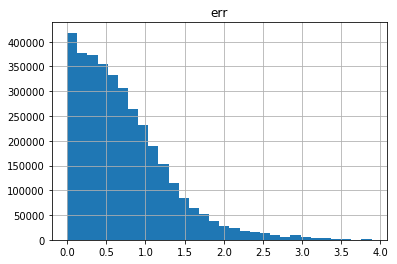

In [0]:
df.hist('err', bins = 30)



In [0]:
# next steps:
# merge with movie title
# try to understand most predictive movies
# try to understand number on rating per movie as a threshhold
# bulid mini recommandation system



**Dean:**  That looks great! 

I think we should "bucket" the errors accourding to 
the number of ratings, or the number of users.

similar code I've done in another project (my home-test for a job)
(RUL is the target label)

# Collaborative Filtering - Sparse MF algorithm (Andrew Ng)
implemented by us from the Coursera Course

## Algorithm (sparse MF):

In [0]:
pivot = movielens.pivot_table(values = 'rating', index = 'movie_id', columns = 'user_id')
pivot.fillna(0, inplace = True)

In [0]:
def cofiCostFunc(params, Y, R, num_users, num_movies,
                      num_features, lambda_=0.0):
    """
    Collaborative filtering cost function.
    
    Parameters
    ----------
    params : array_like
        The parameters which will be optimized. This is a one
        dimensional vector of shape (num_movies x num_users, 1). It is the 
        concatenation of the feature vectors X and parameters Theta.
    
    Y : array_like
        A matrix of shape (num_movies x num_users) of user ratings of movies.
    
    R : array_like
        A (num_movies x num_users) matrix, where R[i, j] = 1 if the 
        i-th movie was rated by the j-th user.
    
    num_users : int
        Total number of users.
    
    num_movies : int
        Total number of movies.
    
    num_features : int
        Number of features to learn.
    
    lambda_ : float, optional
        The regularization coefficient.
    
    Returns
    -------
    J : float
        The value of the cost function at the given params.
    
    grad : array_like
        The gradient vector of the cost function at the given params.
        grad has a shape (num_movies x num_users, 1)
    
    Instructions
    ------------
    Compute the cost function and gradient for collaborative filtering.
    Concretely, you should first implement the cost function (without
    regularization) and make sure it is matches our costs. After that,
    you should implement thegradient and use the checkCostFunction routine 
    to check that the gradient is correct. Finally, you should implement
    regularization.
    
    Notes
    -----
    - The input params will be unraveled into the two matrices:
        X : (num_movies  x num_features) matrix of movie features >>>   X (m * p)
        Theta : (num_users  x num_features) matrix of user features >>> Theta (n * p)

    - You should set the following variables correctly:

        X_grad : (num_movies x num_features) matrix, containing the 
                 partial derivatives w.r.t. to each element of X
        Theta_grad : (num_users x num_features) matrix, containing the 
                     partial derivatives w.r.t. to each element of Theta

    - The returned gradient will be the concatenation of the raveled 
      gradients X_grad and Theta_grad.
    """
    # Unfold the X and Theta matrices from params
    X = params[:num_movies*num_features].reshape(num_movies, num_features) # (m * p)
    Theta = params[num_movies*num_features:].reshape(num_users, num_features) # (n * p)

    # You need to return the following values correctly
    J = 0
    X_grad = np.zeros(X.shape)
    Theta_grad = np.zeros(Theta.shape)

    # ====================== YOUR CODE HERE ======================

    M = np.dot(X, Theta.T)
    Z = np.square(np.multiply(R , M) - Y) # (m * n) 
    J = 0.5 * np.sum(Z)
    
    Z2 = np.multiply(R , M) - Y #(m * n) 

    X_grad = np.dot(Z2,Theta) + lambda_* X  # (m*n)dot(n*p)
    Theta_grad = np.dot(Z2.T,X) + lambda_* Theta # (m*n)dot(m*p)
        
    J +=  0.5*lambda_*(np.sum(np.square(X))+np.sum(np.square(Theta)))
    # =============================================================
    
    grad = np.concatenate([X_grad.ravel(), Theta_grad.ravel()])
    return J, grad

In [0]:
def normalizeRatings(Y, R):
    """
    Preprocess data by subtracting mean rating for every movie (every row).

    Parameters
    ----------
    Y : array_like
        The user ratings for all movies. A matrix of shape (num_movies x num_users).

    R : array_like
        Indicator matrix for movies rated by users. A matrix of shape (num_movies x num_users).

    Returns
    -------
    Ynorm : array_like
        A matrix of same shape as Y, after mean normalization.

    Ymean : array_like
        A vector of shape (num_movies, ) containing the mean rating for each movie.
    """
    m, n = Y.shape
    Ymean = np.zeros(m)
    Ynorm = np.zeros(Y.shape)

    for i in range(m):
        idx = R[i, :] == 1
        Ymean[i] = np.mean(Y[i, idx])
        Ynorm[i, idx] = Y[i, idx] - Ymean[i]

    return Ynorm, Ymean


In [0]:
#  Useful Values
num_movies, num_users = pivot.shape
num_features = 10


In [0]:
#  Y is a 1682x943 matrix, containing ratings (1-5) of 1682 movies by 
#  943 users

Y = pivot.values

#  R is a 1682x943 matrix, where R(i,j) = 1 if and only if user j gave a
#  rating to movie i

idx = np.where(pivot>0)

R = np.zeros_like(Y)

R[idx] = 1

#  X : (num_movies  x num_features) matrix of movie features >>>   X = (1682 X p)
#  Theta : (num_users  x num_features) matrix of user features >>> Theta = (943 X p)

# Set Initial Parameters (Theta, X)
X = np.random.randn(num_movies, num_features)
Theta = np.random.randn(num_users, num_features)

initial_parameters = np.concatenate([X.ravel(), Theta.ravel()])


**Next - try to optimize the training parameters, and use test-train split**

In [0]:
from scipy import optimize

def trainRecommender(Y, R, X, Theta, n_users = 943):
    
    Ynorm, Ymean = normalizeRatings(Y, R)

    # Set options for scipy.optimize.minimize
    options = {'maxiter': 100}

    # Set Regularization
    lambda_ = 10
    res = optimize.minimize(lambda x: cofiCostFunc(x, Ynorm, R, num_users,
                                                   num_movies, num_features, lambda_),
                            initial_parameters,
                            method='TNC',
                            jac=True,
                            options=options)
    theta = res.x

    # Unfold the returned theta back into U and W
    X = theta[:num_movies*num_features].reshape(num_movies, num_features)
    Theta = theta[num_movies*num_features:].reshape(num_users, num_features)

    print('Recommender system learning completed.')
    
    return (X, Theta, Ynorm, Ymean)
    
X, Theta, Ynorm, Ymean = trainRecommender(Y, R, X, Theta)

Recommender system learning completed.


In [0]:
#Predictions:
p = np.dot(X, Theta.T)

#Adding back the mean of every movie, Ymean
predictions = p +  Ymean[:,np.newaxis]  #<< broadcasting, adding the Ymean vector to each column of p

pd.DataFrame(predictions).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609
0,5.020299,3.313386,4.323094,3.987173,3.913902,4.074329,4.517856,4.133638,4.253894,4.281907,4.364387,3.790754,4.196639,3.899172,3.191059,3.264718,3.714995,3.620100,4.297834,3.839726,3.975566,3.887991,4.279534,4.280526,3.823305,3.844617,4.873452,3.843786,4.160640,4.066453,3.867474,3.436198,4.053843,4.153207,4.064059,3.671564,3.581617,3.191378,3.474342,3.978907,...,3.582514,4.186750,3.935984,4.488017,3.850634,2.927744,4.339079,4.040313,4.232621,3.917539,4.076006,3.713674,4.335136,3.731457,2.550273,3.750893,3.695468,4.210062,3.958515,4.444233,3.695653,3.083785,3.412366,4.063433,3.821545,4.071047,4.051008,4.202909,1.386896,4.019180,4.169439,3.026164,4.035158,4.795028,3.449409,4.733999,4.365159,4.337135,4.218139,4.318423
1,3.929422,3.570193,3.864681,3.457279,3.409461,3.586891,3.348663,3.896000,3.685751,3.690572,3.678891,3.326754,3.761402,3.426266,3.453264,3.608644,3.729219,3.381391,3.924233,3.640739,3.472207,3.483611,4.048776,3.731203,3.460987,3.341881,4.149577,3.549399,3.523410,3.625951,3.476551,3.360178,3.526379,3.693882,3.609268,3.487034,3.191409,2.932076,3.318379,3.543332,...,3.070904,3.433349,3.467022,3.822643,3.466651,4.640702,3.801923,3.215736,3.649092,3.599479,3.602419,3.739929,3.605222,3.274921,3.015177,3.565423,3.346617,3.701964,3.392044,3.969816,3.348265,3.595728,3.089313,3.435075,3.476122,3.671883,3.556223,3.637356,3.220989,3.626374,3.670833,3.865828,3.567350,3.964931,3.487165,3.852500,3.580475,3.704033,3.578813,3.666632
2,3.129026,2.748832,2.961807,2.773018,2.764006,2.938637,2.847023,2.966059,2.864563,2.898272,2.896631,2.699789,2.901646,2.747663,2.566298,2.739485,2.798066,2.738720,2.928080,2.797058,2.766440,2.762380,3.052874,2.960913,2.753587,2.730580,3.040122,2.805719,2.827383,2.936110,2.782597,2.667856,2.820506,2.932041,2.845586,2.814535,2.674119,2.478634,2.656071,2.823974,...,2.664983,2.800837,2.800231,2.916679,2.807003,2.917747,2.916869,2.713406,2.865038,2.860016,2.855670,2.844832,2.872473,2.721855,2.424050,2.807479,2.733116,2.873219,2.761861,3.010993,2.626121,2.787791,2.755545,2.826865,2.794629,2.847007,2.809259,2.839752,2.503528,2.791656,2.840342,2.575664,2.838985,3.115571,2.669794,2.980200,2.853196,2.909783,2.814738,2.982867
3,4.005954,4.009078,3.998279,3.991040,3.999149,3.990523,4.007358,4.007518,3.989548,4.002851,3.989087,3.997217,4.003385,3.995898,4.022425,3.996959,3.985582,4.012204,3.995895,4.008483,4.000195,3.998040,4.001890,3.999772,3.999738,4.001928,3.967038,4.002000,3.998002,4.005492,4.003351,4.000836,3.995973,4.007240,3.994642,4.004184,4.006378,4.010652,4.007136,3.999445,...,4.012717,3.984865,4.001607,3.999254,4.006769,4.033914,3.992156,3.995964,3.997244,4.008534,3.996561,3.993933,3.986538,4.015819,4.025114,4.004547,4.009825,3.997177,4.002261,3.996791,3.993860,4.020742,4.001898,4.002685,4.002015,3.996829,3.996510,3.988397,4.048733,3.996604,3.994150,4.005272,4.001429,4.007324,4.001981,3.990539,3.992849,4.004177,3.988785,4.008005
4,3.509151,3.465003,3.472661,3.497621,3.506482,3.495056,3.491949,3.491623,3.498979,3.486082,3.501954,3.508762,3.475645,3.502875,3.445989,3.544567,3.487336,3.500125,3.493137,3.485605,3.495462,3.503346,3.486078,3.486685,3.505865,3.504402,3.514747,3.501210,3.503119,3.459687,3.493641,3.502479,3.500501,3.493892,3.506011,3.507898,3.501356,3.501843,3.508596,3.496355,...,3.519669,3.507170,3.504657,3.496941,3.501634,3.442125,3.498284,3.482356,3.498254,3.484522,3.505709,3.511452,3.510071,3.491468,3.526008,3.509454,3.497625,3.496265,3.502242,3.503891,3.495692,3.511452,3.534798,3.495926,3.500322,3.493886,3.500382,3.503087,3.511551,3.500811,3.491138,3.509492,3.495829,3.480316,3.501348,3.493724,3.503195,3.496738,3.498454,3.501067


## Seeing your own recommendations!

Movie list:

In [0]:
movieList = movies['title']
n_m = len(movieList)
pd.DataFrame(movieList).tail(20)

,title
9723,Iron Soldier (2010)
9724,BlacKkKlansman (2018)
9725,The Darkest Minds (2018)
9726,Tilt (2011)
9727,Jeff Ross Roasts the Border (2017)
9728,John From (2015)
9729,Liquid Truth (2017)
9730,Bunny (1998)
9731,Hommage Ã Zgougou (et salut Ã Sabine Mamou) ...
9732,Gintama (2017)


In [0]:
#Adding our own ratings

#  Initialize my ratings
my_ratings = np.zeros(n_m)


my_ratings[318] = 1
my_ratings[253] = 1

print('Dean ratings:')
print('-----------------')
for i in range(len(my_ratings)):
    if my_ratings[i] > 0:
        print('Rated %d stars: %s' % (my_ratings[i], movieList[i]))

Dean ratings:
-----------------
Rated 1 stars: Poison Ivy II (1996)
Rated 1 stars: I Like It Like That (1994)


In [0]:
movies.iloc[310:320, ]

,movie_id,title
310,351,"Corrina, Corrina (1994)"
311,352,Crooklyn (1994)
312,353,"Crow, The (1994)"
313,354,Cobb (1994)
314,355,"Flintstones, The (1994)"
315,356,Forrest Gump (1994)
316,357,Four Weddings and a Funeral (1994)
317,358,Higher Learning (1995)
318,359,I Like It Like That (1994)
319,360,I Love Trouble (1994)


In [0]:
Y.shape, R.shape, X.shape, Theta.shape

((1682, 943), (1682, 943), (1682, 10), (943, 10))

In [0]:
# Re-train with new user predictions:

Y = pivot.values
R = Y > 0

print("Adding your recommendations!")
Y = np.hstack([my_ratings[:, None], Y])
R = np.hstack([(my_ratings > 0)[:, None], R])

#  Normalize Ratings
Ynorm, Ymean = normalizeRatings(Y, R)

#  Useful Values
num_movies, num_users = Y.shape
num_features = 15

# Set Initial Parameters (Theta, X)
X = np.random.randn(num_movies, num_features)
Theta = np.random.randn(num_users, num_features)

initial_parameters = np.concatenate([X.ravel(), Theta.ravel()])

# Set options for scipy.optimize.minimize
options = {'maxiter': 100}

# Set Regularization
lambda_ = 10

#Optimizing using Gradient Descent (in scipy)
res = optimize.minimize(lambda x: cofiCostFunc(x, Ynorm, R, num_users,
                                               num_movies, num_features, lambda_),
                        initial_parameters,
                        method='TNC',
                        jac=True,
                        options=options)
theta = res.x

# Unfold the returned theta back into U and W
X = theta[:num_movies*num_features].reshape(num_movies, num_features)
Theta = theta[num_movies*num_features:].reshape(num_users, num_features)

print('Recommender system learning completed.')


#Predictions:
p = np.dot(X, Theta.T)

#Adding back the mean of every movie, Ymean
predictions = p +  Ymean[:,np.newaxis]  #<< broadcasting, adding the Ymean vector to each column of p

my_predictions = predictions[:,0]

Adding your recommendations!
Recommender system learning completed.


In [0]:
ix = np.argsort(my_predictions)[::-1]

print('Top recommendations for you:')
print('----------------------------')
for i in range(10):
    j = ix[i]
    print('Predicting rating %.1f for movie %s' % (my_predictions[j], movieList[j]))

print('\nOriginal ratings provided:')
print('--------------------------')
for i in range(len(my_ratings)):
    if my_ratings[i] > 0:
        print('Rated %d for %s' % (my_ratings[i], movieList[i]))

Top recommendations for you:
----------------------------
Predicting rating 6.3 for movie Night Flier (1997)
Predicting rating 5.2 for movie Touch (1997)
Predicting rating 5.2 for movie Junior (1994)
Predicting rating 5.1 for movie Love Bug, The (1969)
Predicting rating 5.1 for movie Star Trek VI: The Undiscovered Country (1991)
Predicting rating 5.1 for movie Winnie the Pooh and the Blustery Day (1968)
Predicting rating 5.1 for movie Big Squeeze, The (1996)
Predicting rating 5.0 for movie Death and the Maiden (1994)
Predicting rating 5.0 for movie Deer Hunter, The (1978)
Predicting rating 5.0 for movie Late Bloomers (1996)

Original ratings provided:
--------------------------
Rated 1 for Batman & Robin (1997)
Rated 1 for Men in Black (1997)


In [0]:
ix = np.argsort(my_predictions)[::-1]

print('Top recommendations for you:')
print('----------------------------')
for i in range(10):
    j = ix[i]
    print('Predicting rating %.1f for movie %s' % (my_predictions[j], movieList[j]))

print('\nOriginal ratings provided:')
print('--------------------------')
for i in range(len(my_ratings)):
    if my_ratings[i] > 0:
        print('Rated %d for %s' % (my_ratings[i], movieList[i]))

Top recommendations for you:
----------------------------
Predicting rating 5.0 for movie Deer Hunter, The (1978)
Predicting rating 5.0 for movie Star Trek VI: The Undiscovered Country (1991)
Predicting rating 5.0 for movie Unbearable Lightness of Being, The (1988)
Predicting rating 5.0 for movie Conspiracy Theory (1997)
Predicting rating 5.0 for movie Junior (1994)
Predicting rating 5.0 for movie Farinelli: il castrato (1994)
Predicting rating 5.0 for movie Love Bug, The (1969)
Predicting rating 5.0 for movie Nightwatch (1997)
Predicting rating 5.0 for movie Audrey Rose (1977)
Predicting rating 5.0 for movie Big Squeeze, The (1996)

Original ratings provided:
--------------------------
Rated 5 for Return of the Jedi (1983)
Rated 5 for 101 Dalmatians (1996)
Rated 5 for Austin Powers: International Man of Mystery (1997)
Rated 5 for Lost World: Jurassic Park, The (1997)
Rated 5 for Batman & Robin (1997)
Rated 5 for Men in Black (1997)


In [0]:
Test Predictions

N_min = min num of ratings per user
M_min = min number of ratings per movie

create new matrix based on N_min and M_min

TrainSet = for each instance reduce %of|constant from sample (e.g. leave out 5 randim ratings to test predictions)
TestSet = predictions left out

make prediction on TrainSet
calculate RMSE for each user
total score = mean of RMSE ?

which movies got the lowest RMSE?
check number of ratings per movie * RMSE

create the UltimateList - 10-15 movie list that can be splited ot Train-Test and will preform 

In [0]:
ratings.iloc[:,:3]

,user_id,movie_id,rating
0,195,241,3.000
1,185,301,3.000
2,21,376,1.000
3,243,50,2.000
4,165,345,1.000
...,...,...,...
99995,879,475,3.000
99996,715,203,5.000
99997,275,1089,1.000
99998,12,224,2.000


In [0]:
from scipy.sparse import csr_matrix

# pivot ratings into movie features
df_movie_features = ratings.iloc[:,:3].pivot(
    index='movie_id',
    columns='user_id',
    values='rating'
).fillna(0)
# convert dataframe of movie features to scipy sparse matrix
mat_movie_features = csr_matrix(df_movie_features.values)

In [0]:
reader = Reader(rating_scale=(1, 5))

NameError: ignored

## Train-test splitting, Evaluation
We implemented a unique way to split the data and calculate MSE.

### Loading U1_base and U2_train data:

In [0]:
# Load each data set (users, movies, and ratings).
ratings_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']

train_df = pd.read_csv(
    'ml-100k/ua.base', sep='\t', names=ratings_cols, encoding='latin-1')

test_df = pd.read_csv(
    'ml-100k/ua.test', sep='\t', names=ratings_cols, encoding='latin-1')

In [0]:
movielens.head()

,user_id,movie_id,rating,unix_timestamp,title,release_date,video_release_date,imdb_url,genre_unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,year,genre,all_genres,age,sex,occupation,zip_code
0,195,241,3.0,881250949,Kolya (1996),24-Jan-1997,NaN,http://us.imdb.com/M/title-exact?Kolya%20(1996),0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1997,Comedy,Comedy,49,M,writer,55105
1,195,256,2.0,881251577,Men in Black (1997),04-Jul-1997,NaN,http://us.imdb.com/M/title-exact?Men+in+Black+...,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1997,Sci-Fi,Action-Adventure-Comedy-Sci-Fi,49,M,writer,55105
2,195,110,4.0,881251793,"Truth About Cats & Dogs, The (1996)",26-Apr-1996,NaN,http://us.imdb.com/M/title-exact?Truth%20About...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1996,Comedy,Comedy-Romance,49,M,writer,55105
3,195,24,4.0,881251955,"Birdcage, The (1996)",08-Mar-1996,NaN,"http://us.imdb.com/M/title-exact?Birdcage,%20T...",0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1996,Comedy,Comedy,49,M,writer,55105
4,195,381,4.0,881251843,"Adventures of Priscilla, Queen of the Desert, ...",01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?Adventures%20...,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1994,Comedy,Comedy-Drama,49,M,writer,55105


In [0]:
min_user_clicks = 50
filter_users = train_df['user_id'].value_counts() > min_user_clicks
filter_users = filter_users[filter_users].index.tolist()

df_filtered = train_df[(train_df['user_id'].isin(filter_users))]
print('The original data frame shape:\t{}'.format(train_df.shape))
print('The new data frame shape:\t{}'.format(df_filtered.shape))

The original data frame shape:	(90570, 4)
The new data frame shape:	(79476, 4)


In [0]:
#Filtering out users from the test set, 
#that do not exist in the training set (after min_clicks cleaning)
idx = list(df_filtered.user_id.unique())
test_df['filter'] = False

for i, val in test_df.iterrows():
    if (test_df.user_id[i] in idx):
        test_df.loc[i,'filter']=True
        
test_df_drop = test_df[test_df['filter']==True]


In [0]:
#In addition to the user-cleaning from the test set, 
# some movies may exist in the test set that were removed in the training set.
# Therefore we remove those too.

idx = list(df_filtered.movie_id.unique())
test_df_drop['filter_movies'] = False

for i, val in test_df_drop.iterrows():
    if (test_df_drop.movie_id[i] in idx):
        test_df_drop.loc[i,'filter_movies']=True
        
test_df_drop = test_df_drop[test_df_drop['filter_movies']==True]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [0]:
test_df_drop.filter_movies.value_counts()

True    4938
Name: filter_movies, dtype: int64

In [0]:
pivot_train = df_filtered.pivot_table(values = 'rating', index = 'movie_id', columns = 'user_id')
pivot_train.fillna(0, inplace = True)

pivot_test = test_df_drop.pivot_table(values = 'rating', index = 'movie_id', columns = 'user_id')
pivot_test.fillna(0, inplace = True)

In [0]:
pivot_train.shape, pivot_test.shape

((1675, 494), (1017, 494))

In [0]:
pivot_test.head(5)

user_id,1,2,5,6,7,10,11,13,14,15,16,18,21,22,23,24,25,26,28,38,42,43,44,48,49,54,56,57,58,59,60,62,63,64,65,69,70,72,73,75,...,877,878,880,881,882,883,885,886,887,889,890,892,894,896,897,899,901,903,907,908,911,913,916,918,919,921,922,923,924,927,930,931,932,933,934,936,938,940,942,943
movie_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
pivot_train.head(5)

user_id,1,2,5,6,7,10,11,13,14,15,16,18,21,22,23,24,25,26,28,38,42,43,44,48,49,54,56,57,58,59,60,62,63,64,65,69,70,72,73,75,...,877,878,880,881,882,883,885,886,887,889,890,892,894,896,897,899,901,903,907,908,911,913,916,918,919,921,922,923,924,927,930,931,932,933,934,936,938,940,942,943
movie_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,5.0,4.0,0.0,4.0,0.0,4.0,0.0,3.0,0.0,1.0,5.0,5.0,5.0,0.0,5.0,0.0,5.0,3.0,0.0,5.0,5.0,5.0,4.0,0.0,2.0,4.0,4.0,5.0,5.0,2.0,0.0,2.0,3.0,4.0,3.0,0.0,4.0,4.0,2.0,4.0,...,0.0,0.0,4.0,4.0,5.0,3.0,0.0,4.0,0.0,3.0,4.0,5.0,4.0,4.0,0.0,3.0,5.0,3.0,5.0,0.0,0.0,2.0,4.0,3.0,4.0,0.0,5.0,3.0,5.0,5.0,3.0,0.0,4.0,3.0,2.0,4.0,4.0,0.0,0.0,0.0
2,3.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,3.0,0.0,0.0,...,0.0,0.0,3.0,0.0,0.0,0.0,0.0,4.0,0.0,3.0,0.0,4.0,0.0,3.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,5.0
3,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,4.0,0.0,3.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0
4,3.0,0.0,0.0,0.0,5.0,4.0,0.0,5.0,0.0,0.0,5.0,3.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,4.0,3.0,4.0,4.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,4.0,4.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,5.0,0.0,0.0,2.0,0.0,0.0
5,3.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,...,0.0,0.0,3.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,3.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
print("Train set contains {} ratings".format(np.sum(np.sum(pivot_train>0))))
print("Test set contains {} ratings".format(np.sum(np.sum(pivot_test>0))))

Train set contains 79476 ratings
Test set contains 4938 ratings


In [0]:
#Checking if users in the test set are included in the train set

s_test = set(test_df_drop.user_id)
s_train = set(df_filtered.user_id)

inter = s_train.intersection(s_test)
len(inter), len(s_train)

(494, 494)

In [0]:
#Checking if movies in the test set are included in the train set

s_test = set(test_df_drop.movie_id)
s_train = set(df_filtered.movie_id)

inter = s_test.issubset(s_train)
inter, len(s_train), len(s_test)

(True, 1675, 1017)

### Training the CF algorithm on the train-pivot table, to test it later over the test pivot table:

In [0]:
from scipy import optimize

#  Y is a 1682x943 matrix, containing ratings (1-5) of 1682 movies by 943 users

Y = pivot_train.values

#  R is a 1682x943 matrix, where R(i,j) = 1 if and only if user j gave a rating to movie i

idx = np.where(pivot_train>0)

R = np.zeros_like(Y)

R[idx] = 1

#  Useful Values
num_movies, num_users = pivot_train.shape
num_features = [5,10,15, 30, 50]
# Set Regularization

lambda_ = [10, 20, 50, 100]
# Set options for scipy.optimize.minimize
options = [{'maxiter': 50}, {'maxiter': 100}, {'maxiter': 150}, {'maxiter': 200}, {'maxiter': 300}, {'maxiter': 400}]

In [0]:
def cofiCostFunc(params, Y, R, num_users, num_movies,
                      num_features, lambda_=0.0):
    """
    Collaborative filtering cost function.
    
    Parameters
    ----------
    params : array_like
        The parameters which will be optimized. This is a one
        dimensional vector of shape (num_movies x num_users, 1). It is the 
        concatenation of the feature vectors X and parameters Theta.
    
    Y : array_like
        A matrix of shape (num_movies x num_users) of user ratings of movies.
    
    R : array_like
        A (num_movies x num_users) matrix, where R[i, j] = 1 if the 
        i-th movie was rated by the j-th user.
    
    num_users : int
        Total number of users.
    
    num_movies : int
        Total number of movies.
    
    num_features : int
        Number of features to learn.
    
    lambda_ : float, optional
        The regularization coefficient.
    
    Returns
    -------
    J : float
        The value of the cost function at the given params.
    
    grad : array_like
        The gradient vector of the cost function at the given params.
        grad has a shape (num_movies x num_users, 1)
    
    Instructions
    ------------
    Compute the cost function and gradient for collaborative filtering.
    Concretely, you should first implement the cost function (without
    regularization) and make sure it is matches our costs. After that,
    you should implement thegradient and use the checkCostFunction routine 
    to check that the gradient is correct. Finally, you should implement
    regularization.
    
    Notes
    -----
    - The input params will be unraveled into the two matrices:
        X : (num_movies  x num_features) matrix of movie features >>>   X (m * p)
        Theta : (num_users  x num_features) matrix of user features >>> Theta (n * p)

    - You should set the following variables correctly:

        X_grad : (num_movies x num_features) matrix, containing the 
                 partial derivatives w.r.t. to each element of X
        Theta_grad : (num_users x num_features) matrix, containing the 
                     partial derivatives w.r.t. to each element of Theta

    - The returned gradient will be the concatenation of the raveled 
      gradients X_grad and Theta_grad.
    """
    # Unfold the X and Theta matrices from params
    X = params[:num_movies*num_features].reshape(num_movies, num_features) # (m * p)
    Theta = params[num_movies*num_features:].reshape(num_users, num_features) # (n * p)

    # You need to return the following values correctly
    J = 0
    X_grad = np.zeros(X.shape)
    Theta_grad = np.zeros(Theta.shape)

    # ====================== YOUR CODE HERE ======================

    M = np.dot(X, Theta.T)
    Z = np.square(np.multiply(R , M) - Y) # (m * n) 
    J = 0.5 * np.sum(Z)
    
    Z2 = np.multiply(R , M) - Y #(m * n) 

    X_grad = np.dot(Z2,Theta) + lambda_* X  # (m*n)dot(n*p)
    Theta_grad = np.dot(Z2.T,X) + lambda_* Theta # (m*n)dot(m*p)
        
    J +=  0.5*lambda_*(np.sum(np.square(X))+np.sum(np.square(Theta)))
    # =============================================================
    
    grad = np.concatenate([X_grad.ravel(), Theta_grad.ravel()])
    return J, grad

In [0]:
def trainRecommender(Y, R, X, Theta, n_users, features, reg, option, verbose=1):
    
    Ynorm, Ymean = normalizeRatings(Y, R)

    res = optimize.minimize(lambda x: cofiCostFunc(x, Ynorm, R, num_users,
                                                   num_movies, features, reg),
                            initial_parameters,
                            method='TNC',
                            jac=True,
                            options=option)
    theta = res.x

    # Unfold the returned theta back into U and W
    X = theta[:num_movies*features].reshape(num_movies, features)
    Theta = theta[num_movies*features:].reshape(num_users, features)

    if verbose:
        print('Recommender system learning completed.')
    
    return (X, Theta, Ynorm, Ymean)

In [0]:
def normalizeRatings(Y, R):
    """
    Preprocess data by subtracting mean rating for every movie (every row).

    Parameters
    ----------
    Y : array_like
        The user ratings for all movies. A matrix of shape (num_movies x num_users).

    R : array_like
        Indicator matrix for movies rated by users. A matrix of shape (num_movies x num_users).

    Returns
    -------
    Ynorm : array_like
        A matrix of same shape as Y, after mean normalization.

    Ymean : array_like
        A vector of shape (num_movies, ) containing the mean rating for each movie.
    """
    m, n = Y.shape
    Ymean = np.zeros(m)
    Ynorm = np.zeros(Y.shape)

    for i in range(m):
        idx = R[i, :] == 1
        Ymean[i] = np.mean(Y[i, idx])
        Ynorm[i, idx] = Y[i, idx] - Ymean[i]

    return Ynorm, Ymean


In [0]:
pd.DataFrame(predictions).shape

(514, 471)

In [0]:
#Lazy Grid Search - looping over all the options

results = []
rnd = 0

for ftrs in num_features:
    for regu in lambda_:
        for option in options:
            
            #  X : (num_movies  x num_features) matrix of movie features >>>   X = (1682 X p)
            #  Theta : (num_users  x num_features) matrix of user features >>> Theta = (943 X p)

            # Set Initial Parameters (Theta, X)
            X = np.random.randn(num_movies, ftrs)
            Theta = np.random.randn(num_users, ftrs)

            initial_parameters = np.concatenate([X.ravel(), Theta.ravel()])
            
            X, Theta, Ynorm, Ymean = trainRecommender(Y, R, X, Theta, num_users, ftrs, regu, option)
            
            #Predictions:
            p = np.dot(X, Theta.T)

            #Adding back the mean of every movie, Ymean
            predictions = p +  Ymean[:,np.newaxis]  #<< broadcasting, adding the Ymean vector to each column of p

            train_predictions = pd.DataFrame(predictions)
            train_predictions.columns = list(range(1,num_users+1))
            
            '''
            The best way I've found to do this..
            Looping over the test pivot and locating the corresponding cell in the train set,
            by INDEX, where the test-pivot has a rating.
            '''
            true_val = []
            validation_val = []
            for i, row in pivot_test.iterrows():
                idx = i
                for j, cell in enumerate(row):
                    jdx = j
                    if cell!=0 and (pivot_test.columns[j] in pivot_train.columns):
                        validation_val.append(train_predictions.iloc[i,j])
                        true_val.append(cell)
                        
            true_val = np.array(true_val)
            validation_val = np.array(validation_val)
            MSE = np.round(np.square(true_val - validation_val).mean(),4)
            MAE = np.round(np.abs(true_val - validation_val).mean(),4)
            
            print('MSE: {}, MAE: {}'.format(MSE, MAE))
            print("number of features: {}, iter: {}, lambda: {}".format(ftrs, option, regu))
            
            results.append([MSE, MAE, ftrs, option, regu])
            rnd+=1

Recommender system learning completed.
MSE: 1.476, MAE: 0.9727
number of features: 5, iter: {'maxiter': 50}, lambda: 10
Recommender system learning completed.
MSE: 1.4469, MAE: 0.959
number of features: 5, iter: {'maxiter': 100}, lambda: 10
Recommender system learning completed.
MSE: 1.4529, MAE: 0.9595
number of features: 5, iter: {'maxiter': 150}, lambda: 10
Recommender system learning completed.
MSE: 1.4492, MAE: 0.9592
number of features: 5, iter: {'maxiter': 200}, lambda: 10
Recommender system learning completed.
MSE: 1.4501, MAE: 0.9592
number of features: 5, iter: {'maxiter': 300}, lambda: 10
Recommender system learning completed.
MSE: 1.4502, MAE: 0.9594
number of features: 5, iter: {'maxiter': 400}, lambda: 10
Recommender system learning completed.
MSE: 1.4493, MAE: 0.9649
number of features: 5, iter: {'maxiter': 50}, lambda: 20
Recommender system learning completed.
MSE: 1.4313, MAE: 0.9578
number of features: 5, iter: {'maxiter': 100}, lambda: 20
Recommender system learning 

In [0]:
results = pd.DataFrame(results)
results.columns = ['RMSE', 'MAE', 'NumOfFeatures', 'Iter', 'Lambda']
results.RMSE = np.sqrt(results.RMSE)

print("Grid search results:")
results.sort_values(by='MAE')

Grid search results:


,RMSE,MAE,NumOfFeatures,Iter,Lambda
6,1.011189,0.9566,5,{'maxiter': 50},20
0,1.011583,0.9569,5,{'maxiter': 50},10
79,1.011255,0.9575,30,{'maxiter': 100},20
11,1.011278,0.9577,5,{'maxiter': 400},20
10,1.011278,0.9577,5,{'maxiter': 300},20
9,1.011278,0.9577,5,{'maxiter': 200},20
30,1.011264,0.9577,10,{'maxiter': 50},20
8,1.011280,0.9578,5,{'maxiter': 150},20
103,1.011278,0.9579,50,{'maxiter': 100},20
34,1.011280,0.9580,10,{'maxiter': 300},20


#Movie-lens 2018 (Sparse MF)

## Data

In [0]:
#Some Imports 
import numpy as np
import pandas as pd
import collections
import seaborn as sns
%matplotlib inline
from IPython import display
from matplotlib import pyplot as plt
import sklearn
import sklearn.manifold

#Get the Data
#NEW MOVIELENS - download the NEW MovieLens Data, and create DataFrames containing movies, users, and ratings.

print("Downloading movielens data...")
import zipfile
import urllib.request

    
urllib.request.urlretrieve("http://files.grouplens.org/datasets/movielens/ml-latest-small.zip", "movielens.zip")

zip_ref = zipfile.ZipFile('movielens.zip', "r")
zip_ref.extractall()

ratings_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings = pd.read_csv('ml-latest-small/ratings.csv', names=ratings_cols, sep=',', encoding='latin-1', header = None)
ratings.drop([0], inplace=True)
ratings.drop('unix_timestamp', axis =1, inplace=True)

movies_cols = ['movie_id', 'title', 'genres']
movies = pd.read_csv('ml-latest-small/movies.csv',names=movies_cols, sep=',', encoding='latin-1')
movies.drop([0], inplace=True)
movies.drop('genres', axis = 1, inplace = True)

# Create one merged DataFrame containing all the movielens data.
movielens = ratings.merge(movies, on='movie_id')
movielens.rating = movielens.rating.astype(float)
movielens.user_id = movielens.user_id.astype(int)
movielens.movie_id = movielens.movie_id.astype(int)

# Utility to split the data into training and test sets.
def split_dataframe(df, holdout_fraction=0.1):
    """Splits a DataFrame into training and test sets.
    Args:
    df: a dataframe.
    holdout_fraction: fraction of dataframe rows to use in the test set.
    Returns:
    train: dataframe for training
    test: dataframe for testing
    """
    test = df.sample(frac=holdout_fraction, replace=False)
    train = df[~df.index.isin(test.index)]
    return train, test



In [0]:
# D O   N O T   R U N ! ! ! 

# Ver1 -  Create a Random Data for Baseline
import random
movielens['rating'] = np.random.randint(1, 6, movielens.shape[0])
movielens.rating = movielens.rating.astype(float)
movielens.head(30)

# Ver2 -  Create a Normalize Distributed Random Data for Baseline
import scipy.stats as ss
import numpy as np
import matplotlib.pyplot as plt

x = np.arange(-2, 3)
xU, xL = x + 0.5, x - 0.5 
prob = ss.norm.cdf(xU, scale = 1) - ss.norm.cdf(xL, scale = 1)
prob = prob / prob.sum() #normalize the probabilities so their sum is 1
nums = np.random.choice(x, size =movielens.shape[0], p = prob)
nums = nums + 3

movielens['rating'] = nums
movielens.rating = movielens.rating.astype(float)
movielens.head()



,user_id,movie_id,rating,title
0,1,1,3.0,Toy Story (1995)
1,5,1,2.0,Toy Story (1995)
2,7,1,3.0,Toy Story (1995)
3,15,1,3.0,Toy Story (1995)
4,17,1,4.0,Toy Story (1995)


## Model

In [0]:
pivot = movielens.pivot_table(values = 'rating', index = 'movie_id', columns = 'user_id')
pivot.fillna(0, inplace = True)

In [0]:
def cofiCostFunc(params, Y, R, num_users, num_movies,
                      num_features, lambda_=0.0):
    """
    Collaborative filtering cost function.
    
    Parameters
    ----------
    params : array_like
        The parameters which will be optimized. This is a one
        dimensional vector of shape (num_movies x num_users, 1). It is the 
        concatenation of the feature vectors X and parameters Theta.
    
    Y : array_like
        A matrix of shape (num_movies x num_users) of user ratings of movies.
    
    R : array_like
        A (num_movies x num_users) matrix, where R[i, j] = 1 if the 
        i-th movie was rated by the j-th user.
    
    num_users : int
        Total number of users.
    
    num_movies : int
        Total number of movies.
    
    num_features : int
        Number of features to learn.
    
    lambda_ : float, optional
        The regularization coefficient.
    
    Returns
    -------
    J : float
        The value of the cost function at the given params.
    
    grad : array_like
        The gradient vector of the cost function at the given params.
        grad has a shape (num_movies x num_users, 1)
    
    Instructions
    ------------
    Compute the cost function and gradient for collaborative filtering.
    Concretely, you should first implement the cost function (without
    regularization) and make sure it is matches our costs. After that,
    you should implement thegradient and use the checkCostFunction routine 
    to check that the gradient is correct. Finally, you should implement
    regularization.
    
    Notes
    -----
    - The input params will be unraveled into the two matrices:
        X : (num_movies  x num_features) matrix of movie features >>>   X (m * p)
        Theta : (num_users  x num_features) matrix of user features >>> Theta (n * p)

    - You should set the following variables correctly:

        X_grad : (num_movies x num_features) matrix, containing the 
                 partial derivatives w.r.t. to each element of X
        Theta_grad : (num_users x num_features) matrix, containing the 
                     partial derivatives w.r.t. to each element of Theta

    - The returned gradient will be the concatenation of the raveled 
      gradients X_grad and Theta_grad.
    """
    # Unfold the X and Theta matrices from params
    X = params[:num_movies*num_features].reshape(num_movies, num_features) # (m * p)
    Theta = params[num_movies*num_features:].reshape(num_users, num_features) # (n * p)

    # You need to return the following values correctly
    J = 0
    X_grad = np.zeros(X.shape)
    Theta_grad = np.zeros(Theta.shape)

    # ====================== YOUR CODE HERE ======================

    M = np.dot(X, Theta.T)
    Z = np.square(np.multiply(R , M) - Y) # (m * n) 
    J = 0.5 * np.sum(Z)
    
    Z2 = np.multiply(R , M) - Y #(m * n) 

    X_grad = np.dot(Z2,Theta) + lambda_* X  # (m*n)dot(n*p)
    Theta_grad = np.dot(Z2.T,X) + lambda_* Theta # (m*n)dot(m*p)
        
    J +=  0.5*lambda_*(np.sum(np.square(X))+np.sum(np.square(Theta)))
    # =============================================================
    
    grad = np.concatenate([X_grad.ravel(), Theta_grad.ravel()])
    return J, grad

In [0]:
def normalizeRatings(Y, R):
    """
    Preprocess data by subtracting mean rating for every movie (every row).

    Parameters
    ----------
    Y : array_like
        The user ratings for all movies. A matrix of shape (num_movies x num_users).

    R : array_like
        Indicator matrix for movies rated by users. A matrix of shape (num_movies x num_users).

    Returns
    -------
    Ynorm : array_like
        A matrix of same shape as Y, after mean normalization.

    Ymean : array_like
        A vector of shape (num_movies, ) containing the mean rating for each movie.
    """
    m, n = Y.shape
    Ymean = np.zeros(m)
    Ynorm = np.zeros(Y.shape)

    for i in range(m):
        idx = R[i, :] == 1
        Ymean[i] = np.mean(Y[i, idx])
        Ynorm[i, idx] = Y[i, idx] - Ymean[i]

    return Ynorm, Ymean


In [0]:
#  Useful Values
num_movies, num_users = pivot.shape
num_features = 10


In [0]:
#  Y is a 1682x943 matrix, containing ratings (1-5) of 1682 movies by 
#  943 users

Y = pivot.values

#  R is a 1682x943 matrix, where R(i,j) = 1 if and only if user j gave a
#  rating to movie i

idx = np.where(pivot>0)

R = np.zeros_like(Y)

R[idx] = 1

#  X : (num_movies  x num_features) matrix of movie features >>>   X = (1682 X p)
#  Theta : (num_users  x num_features) matrix of user features >>> Theta = (943 X p)

# Set Initial Parameters (Theta, X)
X = np.random.randn(num_movies, num_features)
Theta = np.random.randn(num_users, num_features)

initial_parameters = np.concatenate([X.ravel(), Theta.ravel()])


In [0]:
from scipy import optimize

def trainRecommender(Y, R, X, Theta, n_users = 943):
    
    Ynorm, Ymean = normalizeRatings(Y, R)

    # Set options for scipy.optimize.minimize
    options = {'maxiter': 100}

    # Set Regularization
    lambda_ = 10
    res = optimize.minimize(lambda x: cofiCostFunc(x, Ynorm, R, num_users,
                                                   num_movies, num_features, lambda_),
                            initial_parameters,
                            method='TNC',
                            jac=True,
                            options=options)
    theta = res.x

    # Unfold the returned theta back into U and W
    X = theta[:num_movies*num_features].reshape(num_movies, num_features)
    Theta = theta[num_movies*num_features:].reshape(num_users, num_features)

    print('Recommender system learning completed.')
    
    return (X, Theta, Ynorm, Ymean)
    
X, Theta, Ynorm, Ymean = trainRecommender(Y, R, X, Theta)

Recommender system learning completed.


In [0]:
#Predictions:
p = np.dot(X, Theta.T)

#Adding back the mean of every movie, Ymean
predictions = p +  Ymean[:,np.newaxis]  #<< broadcasting, adding the Ymean vector to each column of p

pd.DataFrame(predictions).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609
0,2.958274,2.928583,2.969944,2.759122,2.914388,3.243831,2.989084,3.018421,2.996292,2.985064,3.004707,2.927244,3.012386,3.027360,3.099424,2.888253,2.914051,2.469945,2.588055,3.294047,2.737194,2.961968,2.936112,2.982273,2.907497,2.987538,2.763446,3.318889,2.825625,2.924302,3.136568,3.057916,3.070731,2.966223,3.005684,2.952484,3.030594,3.045444,2.972203,3.021322,...,3.079850,3.053088,3.137889,3.027112,3.059172,2.980965,3.040445,2.954340,3.048658,2.781427,3.007271,3.023303,3.002793,2.982634,2.968817,2.958905,2.888724,2.978270,2.973623,3.103582,3.027413,3.059414,2.895860,2.841157,2.998016,2.670832,2.449227,3.020320,2.983533,2.863295,2.896243,3.125505,3.041039,2.890254,2.902862,2.529774,2.910720,3.535207,2.743749,3.543847
1,3.265990,3.090658,3.012521,3.165260,3.108188,2.971156,3.027011,2.961964,3.032041,2.927301,2.964025,3.035953,3.014228,2.975819,2.894330,3.194470,3.121495,3.181110,3.552308,2.695677,3.277391,2.977269,3.053486,3.070671,3.132493,3.016257,3.108185,3.243772,3.231181,3.071450,2.871448,3.070474,2.926522,3.053711,3.017166,3.074766,2.945123,2.923615,3.145454,3.017744,...,2.946406,2.894268,2.852022,2.968041,2.937567,3.032654,2.887015,2.985075,3.046266,3.137094,2.929301,3.031604,2.948728,3.126917,3.052873,3.049990,3.052595,3.017026,2.980530,2.432131,3.007165,2.933696,3.137716,3.260346,3.030302,3.205708,3.437206,3.030977,2.448707,3.464847,2.794347,2.935511,2.605961,3.192274,2.880761,3.039412,3.034195,2.855672,3.150425,3.016795
2,2.950295,2.946728,2.866347,2.867522,2.863839,2.616584,2.883870,2.891839,2.902164,2.801089,2.880148,2.893678,2.864290,2.877721,2.979846,2.859398,2.975717,2.569124,2.799409,2.843176,2.877139,2.832525,2.845537,2.940574,2.932844,2.863898,2.808200,2.999763,2.805908,2.884278,2.853867,2.873307,2.997147,2.812989,2.864690,2.868481,2.889697,2.865834,2.879126,2.998839,...,2.914047,2.918329,3.028992,2.864910,2.906652,2.913110,2.850506,2.883312,2.883942,2.784624,2.918299,2.811924,2.897036,2.848256,2.924626,2.867835,3.006594,2.976362,2.891191,3.205819,2.917711,2.865410,2.908282,2.829009,2.939906,2.512126,2.649904,2.896212,1.847488,3.204019,2.835147,2.925105,2.559549,2.914552,2.847891,3.009054,2.835767,3.058454,2.835885,3.617078
3,3.612152,3.751570,3.721582,3.785689,3.680112,3.326576,3.820165,3.705848,3.717282,3.672824,3.699788,3.713306,3.707134,3.719103,3.760251,3.692757,3.748942,3.740331,3.893866,3.693510,3.883944,3.740628,3.713699,3.714455,3.704300,3.688262,3.704923,3.619747,3.597270,3.710847,3.770523,3.673645,3.814282,3.730379,3.683297,3.664506,3.747358,3.737461,3.680393,3.753342,...,3.680768,3.749801,3.762210,3.717716,3.729186,3.731028,3.759872,3.718466,3.669765,3.794446,3.714099,3.658448,3.724246,3.694692,3.740848,3.636060,3.780912,3.774915,3.720978,4.029597,3.738380,3.727661,3.728171,3.727416,3.726776,3.619519,3.500379,3.719801,3.768857,3.881189,3.749450,3.747488,3.946372,3.629802,3.706603,3.857026,3.697651,3.133928,3.694498,3.809922
4,2.862067,2.861005,2.859738,2.903150,2.885210,2.761724,3.057220,2.972674,2.923071,2.991972,2.855316,2.918731,2.856376,2.976979,2.896729,2.746894,2.813691,2.598638,2.201322,3.014962,2.554962,2.876993,2.787811,2.820696,2.846701,2.832530,2.878255,2.905108,2.826895,2.810521,2.975810,2.873899,2.905110,2.844691,2.887933,2.778633,2.893278,2.883540,2.897399,2.963371,...,2.818042,2.856873,3.125704,2.869734,2.902973,2.883499,2.954784,2.843867,2.913606,2.956047,2.880848,2.860993,2.910833,2.874276,2.952672,2.955688,2.875515,2.841044,2.873878,3.493998,3.000243,2.948359,2.832412,2.917601,2.889806,2.515935,2.523241,2.909107,4.012375,3.443053,2.917700,2.849723,2.756510,2.765346,2.854814,3.177562,2.899968,2.415859,2.793205,3.474494


##Train Test Split & Model Evaluation

In [0]:
train_df = movielens.sample(frac=0.8, random_state=0)
test_df = movielens.drop(train_df.index)
train_df.shape, test_df.shape

((80669, 4), (20167, 4))

In [0]:
min_user_clicks = 15
filter_users = train_df['user_id'].value_counts() > min_user_clicks
filter_users = filter_users[filter_users].index.tolist()

min_item_clicks = 15
filter_items = train_df['movie_id'].value_counts() > min_item_clicks
filter_items = filter_items[filter_items].index.tolist()

train_filtered = train_df[(train_df['user_id'].isin(filter_users)) & train_df['movie_id'].isin(filter_items)]
print('The original data frame shape:\t{}'.format(train_df.shape))
print('The new data frame shape:\t{}'.format(train_filtered.shape))


The original data frame shape:	(80669, 4)
The new data frame shape:	(54264, 4)


In [0]:
#Check that all users appears in both Train & Test

train_users_idx = list(train_filtered.user_id.unique())
test_df_idx = list(test_df.user_id.unique())
iters = list(set(train_users_idx) & set(test_df_idx))


train_filtered = train_filtered[train_filtered.user_id.isin(iters)]
test_df = test_df[test_df.user_id.isin(iters)]

In [0]:
#Check that all movies in Test appears in Train

train_movies_inx = list(train_filtered.movie_id.unique())
test_movies_inx = list(test_df.movie_id.unique())
uniques_movies_test = list(np.setdiff1d(test_movies_inx, train_movies_inx))
flt_lst = list(np.setdiff1d(test_movies_inx, uniques_movies_test))


test_df = test_df[test_df['movie_id'].isin(flt_lst)]

In [0]:
train_users = list(train_filtered.user_id.unique())
test_users = list(test_df.user_id.unique())
counter=0
for user in test_users:
    if user not in train_users:
        counter =+ 1
print("Number of non overlaps in users = {}".format(counter))

train_movies = list(train_filtered.movie_id.unique())
test_movies = list(test_df.movie_id.unique())
counter=0
for movie in test_movies:
    if movie not in train_movies:
        counter =counter + 1

print("Number movies in test that are not in train = {}".format(counter))

Number of non overlaps in users = 0
Number movies in test that are not in train = 0


In [0]:
pivot_train = train_filtered.pivot_table(values = 'rating', index = 'movie_id', columns = 'user_id')
pivot_train.fillna(0, inplace = True)

pivot_test = test_df.pivot_table(values = 'rating', index = 'movie_id', columns = 'user_id')
pivot_test.fillna(0, inplace = True)

In [0]:
pivot_train.shape, pivot_test.shape

((1290, 598), (1280, 596))

In [0]:
pivot_train.head()

user_id,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,27,28,29,30,31,32,33,34,36,37,38,39,40,41,42,...,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,599,600,601,602,603,604,605,606,607,608,609,610
movie_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,3.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,3.0,3.0,3.0,0.0,3.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,3.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,...,3.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,2.0,3.0,0.0,0.0,0.0,3.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,2.0,0.0,4.0,0.0,4.0,1.0,3.0,2.0,0.0,2.0,1.0,3.0
2,0.0,0.0,0.0,0.0,0.0,4.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,5.0,2.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,3.0,0.0,3.0,0.0,5.0,0.0,0.0,0.0,2.0,3.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,3.0,4.0,0.0,0.0,3.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0,4.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,5.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,3.0


In [0]:
pivot_test.head(5)

user_id,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,27,28,29,30,31,32,33,34,36,37,38,39,40,41,42,43,...,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,599,600,601,602,603,604,605,606,607,608,609,610
movie_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,...,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,3.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
print("Train set contains {} ratings".format(np.sum(np.sum(pivot_train>0))))
print("Test set contains {} ratings".format(np.sum(np.sum(pivot_test>0))))

Train set contains 54246 ratings
Test set contains 13165 ratings


In [0]:
#Checking if movies in the test set are included in the train set

s_test = set(pivot_test.columns)
s_train = set(pivot_train.columns)

inter = s_test.issubset(s_train)
inter, len(s_train), len(s_test)

(True, 598, 596)

### Training the CF algorithm on the train-pivot table, to test it later over the test pivot table:

In [0]:
from scipy import optimize

#  Y is a 1682x943 matrix, containing ratings (1-5) of 1682 movies by 943 users

Y = pivot_train.values

#  R is a 1682x943 matrix, where R(i,j) = 1 if and only if user j gave a rating to movie i

idx = np.where(pivot_train>0)

R = np.zeros_like(Y)

R[idx] = 1

#  Useful Values
num_movies, num_users = pivot_train.shape
num_features = [1, 5,10]
# Set Regularization

lambda_ = [3,4,5]
# Set options for scipy.optimize.minimize
options = [{'maxiter': 80}, {'maxiter': 100},{'maxiter': 125}, {'maxiter': 150}]

In [0]:
def trainRecommender(Y, R, X, Theta, n_users, features, reg, option, verbose=0):
    
    Ynorm, Ymean = normalizeRatings(Y, R)

    res = optimize.minimize(lambda x: cofiCostFunc(x, Ynorm, R, num_users,
                                                   num_movies, features, reg),
                            initial_parameters,
                            method='TNC',
                            jac=True,
                            options=option)
    theta = res.x

    # Unfold the returned theta back into U and W
    X = theta[:num_movies*features].reshape(num_movies, features)
    Theta = theta[num_movies*features:].reshape(num_users, features)

    if verbose:
        print('Recommender system learning completed.')
    
    return (X, Theta, Ynorm, Ymean)

In [0]:
#Lazy Grid Search - looping over all the options

results = []
rnd = 0

for ftrs in num_features:
    for regu in lambda_:
        for option in options:
            
            #  X : (num_movies  x num_features) matrix of movie features >>>   X = (1682 X p)
            #  Theta : (num_users  x num_features) matrix of user features >>> Theta = (943 X p)

            # Set Initial Parameters (Theta, X)
            X = np.random.randn(num_movies, ftrs)
            Theta = np.random.randn(num_users, ftrs)

            initial_parameters = np.concatenate([X.ravel(), Theta.ravel()])
            
            X, Theta, Ynorm, Ymean = trainRecommender(Y, R, X, Theta, num_users, ftrs, regu, option)
            
            #Predictions:
            p = np.dot(X, Theta.T)

            #Adding back the mean of every movie, Ymean
            predictions = p +  Ymean[:,np.newaxis]  #<< broadcasting, adding the Ymean vector to each column of p

            train_predictions = pd.DataFrame(predictions)
            train_predictions.columns = pivot_train.columns
            
            '''
            The best way I've found to do this..
            Looping over the test pivot and locating the corresponding cell in the train set,
            by INDEX, where the test-pivot has a rating.
            '''
            true_val = []
            validation_val = []
                 
            tmp = list(np.setdiff1d(pivot_test.index, train_predictions.index))
            for i in pivot_test.index:
                for j in pivot_test.columns:
                    if (pivot_test.loc[i,j]!=0) and (i not in tmp):
#                         print('i = {},j = {}'.format(i,j))
                        validation_val.append(train_predictions.loc[i,j])
                        true_val.append(pivot_test.loc[i,j])
                        
            true_val = np.array(true_val)
            validation_val = np.array(validation_val)
            RMSE = np.round(np.sqrt(np.square(true_val - validation_val).mean()),4)
            MAE = np.round(np.abs(true_val - validation_val).mean(),4)
            
            print('RMSE: {}, MAE: {}'.format(RMSE, MAE))
            print("number of features: {}, iter: {}, lambda: {}".format(ftrs, option, regu))
            
            results.append([RMSE, MAE, ftrs, option, regu])
            rnd+=1

RMSE: 1.0327, MAE: 0.8168
number of features: 1, iter: {'maxiter': 80}, lambda: 3
RMSE: 1.029, MAE: 0.8146
number of features: 1, iter: {'maxiter': 100}, lambda: 3
RMSE: 1.0324, MAE: 0.8158
number of features: 1, iter: {'maxiter': 125}, lambda: 3
RMSE: 1.0309, MAE: 0.8154
number of features: 1, iter: {'maxiter': 150}, lambda: 3
RMSE: 1.028, MAE: 0.813
number of features: 1, iter: {'maxiter': 80}, lambda: 4
RMSE: 1.0284, MAE: 0.8147
number of features: 1, iter: {'maxiter': 100}, lambda: 4
RMSE: 1.0251, MAE: 0.811
number of features: 1, iter: {'maxiter': 125}, lambda: 4
RMSE: 1.0299, MAE: 0.8155
number of features: 1, iter: {'maxiter': 150}, lambda: 4
RMSE: 1.0252, MAE: 0.8093
number of features: 1, iter: {'maxiter': 80}, lambda: 5
RMSE: 1.0237, MAE: 0.8063
number of features: 1, iter: {'maxiter': 100}, lambda: 5
RMSE: 1.0268, MAE: 0.8112
number of features: 1, iter: {'maxiter': 125}, lambda: 5
RMSE: 1.025, MAE: 0.8081
number of features: 1, iter: {'maxiter': 150}, lambda: 5
RMSE: 1.1004

KeyboardInterrupt: ignored

In [0]:
results = pd.DataFrame(results)
results.columns = ['RMSE', 'MAE', 'NumOfFeatures', 'Iter', 'Lambda']

print("Grid search results:")
results.sort_values(by='RMSE').head(10)

Grid search results:


,RMSE,MAE,NumOfFeatures,Iter,Lambda
8,1.0943,0.8762,1,{'maxiter': 80},5
7,1.0943,0.8755,1,{'maxiter': 150},4
5,1.0943,0.8755,1,{'maxiter': 100},4
6,1.0943,0.8755,1,{'maxiter': 125},4
9,1.0944,0.8762,1,{'maxiter': 100},5
11,1.0944,0.8762,1,{'maxiter': 150},5
10,1.0944,0.8762,1,{'maxiter': 125},5
0,1.0947,0.8751,1,{'maxiter': 80},3
3,1.0947,0.8751,1,{'maxiter': 150},3
2,1.0947,0.8751,1,{'maxiter': 125},3


In [0]:
#Best Params = 
# NumOfFeatures	=1
# Lambda = 3
# Iter = 80

### Training the algorithm with the best parameters

In [0]:
#  Y is a 1682x943 matrix, containing ratings (1-5) of 1682 movies by 943 users

Y = pivot_train.values

#  R is a 1682x943 matrix, where R(i,j) = 1 if and only if user j gave a rating to movie i

idx = np.where(pivot_train>0)

R = np.zeros_like(Y)

R[idx] = 1

#  Useful Values
num_movies, num_users = pivot_train.shape

ftrs = 1
regu = 3
option = {'maxiter': 80}


X = np.random.randn(num_movies, ftrs)
Theta = np.random.randn(num_users, ftrs)

initial_parameters = np.concatenate([X.ravel(), Theta.ravel()])

X, Theta, Ynorm, Ymean = trainRecommender(Y, R, X, Theta, num_users, ftrs, regu, option)

#Predictions:
p = np.dot(X, Theta.T)

#Adding back the mean of every movie, Ymean
predictions = p +  Ymean[:,np.newaxis]  #<< broadcasting, adding the Ymean vector to each column of p

train_predictions = pd.DataFrame(predictions)
train_predictions.columns = pivot_train.columns

'''
The best way I've found to do this..
Looping over the test pivot and locating the corresponding cell in the train set,
by INDEX, where the test-pivot has a rating.
'''
true_val = []
validation_val = []

tmp = list(np.setdiff1d(pivot_test.index, train_predictions.index))
for i in pivot_test.index:
    for j in pivot_test.columns:
        if (pivot_test.loc[i,j]!=0) and (i not in tmp):
#                         print('i = {},j = {}'.format(i,j))
            validation_val.append(train_predictions.loc[i,j])
            true_val.append(pivot_test.loc[i,j])

true_val = np.array(true_val)
validation_val = np.array(validation_val)
RMSE = np.round(np.sqrt(np.square(true_val - validation_val).mean()),4)
MAE = np.round(np.abs(true_val - validation_val).mean(),4)

print('RMSE: {}, MAE: {}'.format(RMSE, MAE))
print("number of features: {}, iter: {}, lambda: {}".format(ftrs, option, regu))


RMSE: 1.0949, MAE: 0.8753
number of features: 1, iter: {'maxiter': 80}, lambda: 3


In [0]:
pd.DataFrame(zip(true_val ,validation_val), columns = ['true', 'predicted'])

,true,predicted
0,4.5,3.157936
1,3.0,3.514359
2,5.0,4.241178
3,5.0,3.058355
4,4.0,3.516705
5,4.0,3.174579
6,3.0,2.646330
7,2.0,2.797049
8,4.0,3.417857
9,4.5,3.009414


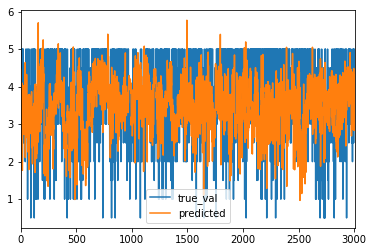

In [0]:
pd.DataFrame(zip(true_val ,validation_val), columns=['true_val', 'predicted']).plot()

## Seeing your own recommendations!

Movie list:

In [0]:
bestmovies = pd.DataFrame(index = movies.movie_id.index)
bestmovies['number of ratings'] =  movielens.pivot_table(index = 'movie_id', values = 'rating', aggfunc='count')
bestmovies['mean of rating'] = round(movielens.pivot_table(index = 'movie_id', values = 'rating', aggfunc='mean'),2)
bestmovies['std of rating'] = round(movielens.pivot_table(index = 'movie_id', values = 'rating', aggfunc='std'), 2)
# bestmovies['movie name'] = movies.loc[movies.movie_id == bestmovies.index]['title']

bestmovies.sort_values(by = 'number of ratings',ascending=False)

# bestmovies.corr()

In [0]:
movieList = movies['title']
movieList['movie_id'] = movies['movie_id']
n_m = len(movieList)
pd.DataFrame(movieList).head(20)

,title
1,Toy Story (1995)
2,Jumanji (1995)
3,Grumpier Old Men (1995)
4,Waiting to Exhale (1995)
5,Father of the Bride Part II (1995)
6,Heat (1995)
7,Sabrina (1995)
8,Tom and Huck (1995)
9,Sudden Death (1995)
10,GoldenEye (1995)


In [0]:
#Adding our own ratings

n_m = pivot_train.values.shape[0]

#  Initialize my ratings
my_ratings = np.zeros(n_m)


# my_ratings[4993] = 5
my_ratings[1080] = 5
my_ratings[260] = 5
# my_ratings[4896] = 5
my_ratings[1196] = 5
my_ratings[1210] = 5
# my_ratings[2628] = 5
# my_ratings[5378] = 5




print('User ratings:')
print('-----------------')

for i, val in enumerate(my_ratings):
    if val > 0:
        print('Rated %d stars: %s' % (val, movies.loc[movies.movie_id==str(i)].title.values))

User ratings:
-----------------
Rated 5 stars: ['Star Wars: Episode IV - A New Hope (1977)']
Rated 5 stars: ["Monty Python's Life of Brian (1979)"]
Rated 5 stars: ['Star Wars: Episode V - The Empire Strikes Back (1980)']
Rated 5 stars: ['Star Wars: Episode VI - Return of the Jedi (1983)']


In [0]:
Y.shape, R.shape, X.shape, Theta.shape

((663, 327), (663, 327), (663, 5), (327, 5))

In [0]:
pivot_train

In [0]:
#  Y is a 1682x943 matrix, containing ratings (1-5) of 1682 movies by 943 users

Y = pivot_train.values

R = Y > 0

print("Adding your recommendations!")
Y = np.hstack([my_ratings[:, None], Y])
R = np.hstack([(my_ratings > 0)[:, None], R])

#  Normalize Ratings
Ynorm, Ymean = normalizeRatings(Y, R)

#  Useful Values
num_movies, num_users = Y.shape

num_features = 30

# Set Initial Parameters (Theta, X)
X = np.random.randn(num_movies, num_features)
Theta = np.random.randn(num_users, num_features)

initial_parameters = np.concatenate([X.ravel(), Theta.ravel()])

# Set options for scipy.optimize.minimize
options = {'maxiter': 50}

# Set Regularization
lambda_ = 20

#Optimizing using Gradient Descent (in scipy)
res = optimize.minimize(lambda x: cofiCostFunc(x, Ynorm, R, num_users,
                                               num_movies, num_features, lambda_),
                        initial_parameters,
                        method='L-BFGS-B',
                        jac=True,
                        options=options)
theta = res.x

# Unfold the returned theta back into U and W
X = theta[:num_movies*num_features].reshape(num_movies, num_features)
Theta = theta[num_movies*num_features:].reshape(num_users, num_features)

print('Recommender system learning completed.')


#Predictions:
p = np.dot(X, Theta.T)

#Adding back the mean of every movie, Ymean
predictions = p +  Ymean[:,np.newaxis]  #<< broadcasting, adding the Ymean vector to each column of p

train_predictions = pd.DataFrame(predictions)
columns = list(pivot_train.columns)
columns = [0] + columns

train_predictions.columns = columns

print(predictions.shape)



true_val = []
validation_val = []

tmp = list(np.setdiff1d(pivot_test.index, train_predictions.index))
for i in pivot_test.index:
    for j in pivot_test.columns:
        if (pivot_test.loc[i,j]!=0) and (i not in tmp):
#             print('i = {},j = {}'.format(i,j))
            validation_val.append(train_predictions.loc[i,j])
            true_val.append(pivot_test.loc[i,j])

true_val = np.array(true_val)
validation_val = np.array(validation_val)
RMSE = np.round(np.sqrt(np.square(true_val - validation_val).mean()),4)
MAE = np.round(np.abs(true_val - validation_val).mean(),4)

print('RMSE: {}, MAE: {}'.format(RMSE, MAE))
my_predictions = predictions[:,0]


Adding your recommendations!
Recommender system learning completed.
(1605, 775)
RMSE: 1.1473, MAE: 0.9199


In [0]:
Y[:,0][np.where(Y[:,0]>0)]

array([5., 5., 5., 5., 5., 5., 5., 5.])

In [0]:
ix = np.argsort(my_predictions)[::-1]

print('Top recommendations for you:')
print('----------------------------')
for i in range(50):
    j = ix[i]
    print('Predicting rating %.3f - %s' % (my_predictions[j], movieList[j]))

print('User ratings:')
print('-----------------')

for i, val in enumerate(my_ratings):
    if val > 0:
        print('Rated %d stars: %s' % (val, movies.loc[movies.movie_id==str(i)].title.values))

Top recommendations for you:
----------------------------
Predicting rating 4.483 - Meet Me in St. Louis (1944)
Predicting rating 4.462 - Congo (1995)
Predicting rating 4.461 - Emma (1996)
Predicting rating 4.452 - Clear and Present Danger (1994)
Predicting rating 4.439 - What's Eating Gilbert Grape (1993)
Predicting rating 4.414 - Thousand Acres, A (1997)
Predicting rating 4.383 - House of the Spirits, The (1993)
Predicting rating 4.376 - Hard Target (1993)
Predicting rating 4.371 - Perfect World, A (1993)
Predicting rating 4.364 - Firm, The (1993)
Predicting rating 4.355 - Scout, The (1994)
Predicting rating 4.351 - Kansas City (1996)
Predicting rating 4.340 - In the Name of the Father (1993)
Predicting rating 4.336 - Shining, The (1980)
Predicting rating 4.327 - Dangerous Minds (1995)
Predicting rating 4.322 - Cheech and Chong's Up in Smoke (1978)
Predicting rating 4.318 - Naked (1993)
Predicting rating 4.317 - Swing Kids (1993)
Predicting rating 4.316 - Star Trek: Generations (1994

In [0]:
#Test Predictions

N_min = min num of ratings per user
M_min = min number of ratings per movie

create new matrix based on N_min and M_min

TrainSet = for each instance reduce %of|constant from sample (e.g. leave out 5 randim ratings to test predictions)
TestSet = predictions left out

make prediction on TrainSet
calculate RMSE for each user
total score = mean of RMSE ?

which movies got the lowest RMSE?
check number of ratings per movie * RMSE

create the UltimateList - 10-15 movie list that can be splited ot Train-Test and will preform 

In [0]:
ratings.iloc[:,:3]

,user_id,movie_id,rating
0,195,241,3.000
1,185,301,3.000
2,21,376,1.000
3,243,50,2.000
4,165,345,1.000
...,...,...,...
99995,879,475,3.000
99996,715,203,5.000
99997,275,1089,1.000
99998,12,224,2.000


In [0]:
from scipy.sparse import csr_matrix

# pivot ratings into movie features
df_movie_features = ratings.iloc[:,:3].pivot(
    index='movie_id',
    columns='user_id',
    values='rating'
).fillna(0)
# convert dataframe of movie features to scipy sparse matrix
mat_movie_features = csr_matrix(df_movie_features.values)